# Team Members & Contributions:

Iain: Obtained AQI data and completed the EDA section for it.

Diego: Obtained demographic data and completed the EDA section for it.

Christina: Tidied AQI data, completed ANOVA testing, and completed linear regression testing.

John: Did not contribute.

# Research Questions

1. How do air quality patterns, as measured through the mean Air Quality Index scores, differ between coastal and inland regions of San Diego county, with coastal regions being measured as the zip codes that contain the coast and inland regions being measured as zip codes that do not contain the coast? 
2. Is there a correlation between the air quality patterns, as measured through the mean Air Quality Index scores, and disparities in health outcomes, as measured by rates of asthma in each zip code, when controlling for other variables (income, median age, etc.)?

# Data Collection and Exploration

In [83]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

First, in order to answer our research questions, we need data on the Air Quality Index scores for each region of San Diego. We found that IQAir, an air quality data resource, has an API on their website for the air quality index scores for each region in San Diego. However, requesting an ID for the API is taking some time, so in the meantime, we have manually obtained some data from the website.

## Wrangling AQI Data

In [84]:
file_path = 'Sample of San Diego AQI.csv'
aqi_df = pd.read_csv(file_path)
aqi_df.head()

,City,"Oct 31, 2025","Nov 1, 2025","Nov 2, 2025","Nov 3, 2025","Nov 4, 2025","Nov 5, 2025","Nov 6, 2025","Nov 7, 2025","Nov 8, 2025","Nov 9, 2025","Nov 10, 2025","Nov 11, 2025","Nov 12, 2025"
0,Petco Park,83,101,113,74,53,41,55,126,106,153,128,104,75
1,Carmel Valley,41,55,57,46,27,23,21,59,52,63,40,51,48
2,La Jolla Shores,72,93,92,64,38,49,57,113,117,143,85,81,77
3,Black Mountain - West Side,53,60,66,55,49,31,34,62,63,62,54,55,52
4,Scripps Ranch,52,56,63,53,43,25,28,62,57,62,52,51,46


First, we need to put this data into tidy form, with each column being a variable and each row being an observation.

In [85]:
tidy_aqi = pd.DataFrame(aqi_df.set_index('City').stack()).reset_index()
tidy_aqi.columns = ['City', 'Date', 'AQI Score']
tidy_aqi.head()

,City,Date,AQI Score
0,Petco Park,"Oct 31, 2025",83
1,Petco Park,"Nov 1, 2025",101
2,Petco Park,"Nov 2, 2025",113
3,Petco Park,"Nov 3, 2025",74
4,Petco Park,"Nov 4, 2025",53


We want to have a common column between the AQI data and the asthma data, so we decided to add the corresponding zip code for each city in the AQI data. For the sake of time in this limited dataset, we created the dictionary for the corresponding zip codes manually. However, in the final project, we want to get the zip codes via web-scraping a website that can look up locations and get their zip codes.

In [86]:
regions = tidy_aqi['City'].unique()
zip_codes = pd.Series([92101, 93924, 92037, 92126, 92131, 92110, 92182, 92104, 92126, 92101, 92071, 92173])
region_to_zip = dict(zip(regions, zip_codes))
zips_series = pd.Series(region_to_zip)
zips_df = pd.DataFrame(zips_series).reset_index()
zips_df.columns = ['City', 'Zip Code']

In [87]:
## Merging
aqi_zip_df = pd.merge(tidy_aqi, zips_df, on='City', how='left')
aqi_zip_df.head()

,City,Date,AQI Score,Zip Code
0,Petco Park,"Oct 31, 2025",83,92101
1,Petco Park,"Nov 1, 2025",101,92101
2,Petco Park,"Nov 2, 2025",113,92101
3,Petco Park,"Nov 3, 2025",74,92101
4,Petco Park,"Nov 4, 2025",53,92101


## EDA for AQI Data

In [88]:
df = aqi_df.set_index('City')

This graph shows us that there are overall trends that influence the air quality patterns for every region, though there is some variation between the regions. For example, every region has comparatively better air quality than normal on November 5th.

***Quick Summary of Cities and Their Avg, Best, and Worst AQI Score***

In [90]:
aqi_summary = pd.DataFrame({
    "Avg AQI": df.mean(axis=1),
    "Best (Lowest) AQI": df.min(axis=1),
    "Worst (Highest) AQI": df.max(axis=1)
}).sort_values("Avg AQI")

aqi_summary

,Avg AQI,Best (Lowest) AQI,Worst (Highest) AQI
City,,,
Carmel Valley,44.846154,21,63
Birchcrest Boulevard (Santee),45.076923,24,64
Mira Mesa,48.923077,19,66
Casa Nova (San Ysidro),49.384615,21,94
Scripps Ranch,50.000000,25,63
USD Athletics,50.000000,24,65
SDSU Athletics,50.384615,26,65
Black Mountain - West Side,53.538462,31,66
San Diego,53.769231,29,69


This is one way of showing us the variability in each region's air quality. Just like in the above graphs, La Jolla Shores and Petco Park have the worst recorded air quality scores, with the other regions remaining far below.

## Obtaining and Cleaning Demographic Data

In [92]:
## Loading packages
#pip install census requests us
import os
import pandas as pd
import numpy as np
from census import Census
from us import states
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [93]:
# Census API key
plt.rcParams["figure.figsize"] = (8, 4)

# --- keys & constants ---
CENSUS_API_KEY = "ce8b9610a02a2db4fd9e5ccb0412895621293667"
c = Census(CENSUS_API_KEY)

In [94]:
STATE_FIPS = states.CA.fips          # '06'
SAN_DIEGO_COUNTY_FIPS = "073"        # San Diego County
START_YEAR = 2018
END_YEAR = 2023

# folder for any local CSVs you download
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [95]:
ACS_VARS = {
    "B01003_001E": "pop_total",
    "B19013_001E": "med_income",
    "B01002_001E": "med_age",
    "B02001_002E": "white_alone",
    "B02001_003E": "black_alone",
    "B02001_005E": "asian_alone",
    "B03002_012E": "hispanic_any",
    "B17001_002E": "pop_below_poverty",
}

acs_cols = tuple(ACS_VARS.keys()) + ("NAME",)

tracts_raw = c.acs5.state_county_tract(
    acs_cols,
    STATE_FIPS,
    SAN_DIEGO_COUNTY_FIPS,
    Census.ALL
)

acs = pd.DataFrame(tracts_raw)
acs.rename(columns=ACS_VARS, inplace=True)

# construct full GEOID
acs["GEOID"] = acs["state"] + acs["county"] + acs["tract"]

# some handy fractions
acs["p_white"] = acs["white_alone"] / acs["pop_total"]
acs["p_black"] = acs["black_alone"] / acs["pop_total"]
acs["p_asian"] = acs["asian_alone"] / acs["pop_total"]
acs["p_hispanic"] = acs["hispanic_any"] / acs["pop_total"]
acs["p_poverty"] = acs["pop_below_poverty"] / acs["pop_total"]

In [96]:
# Classify tracts as coastal or inland based on distance from tract centroids to the coast

def get_tract_centroids(state_fips="06", county_fips="073"):
    layer = 10  # Census Tracts layer
    url = (
        f"https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/{layer}/query"
        f"?where=STATE+%3D+'{state_fips}'+AND+COUNTY+%3D+'{county_fips}'"
        f"&outFields=STATE,COUNTY,TRACT"
        f"&returnGeometry=true&geometryPrecision=6&outSR=4326"
        f"&f=json"
    )

    resp = requests.get(url).json()

    if "features" not in resp:
        print("API returned an error:", resp)
        raise ValueError("TIGERweb query failed")

    rows = []

    for feat in resp["features"]:
        attrs = feat["attributes"]
        geom = feat["geometry"]["rings"][0]

        xs = [p[0] for p in geom]
        ys = [p[1] for p in geom]
        lon = sum(xs) / len(xs)
        lat = sum(ys) / len(ys)

        rows.append({
            "STATE": attrs["STATE"],
            "COUNTY": attrs["COUNTY"],
            "TRACT": attrs["TRACT"],
            "centroid_lon": lon,
            "centroid_lat": lat
        })

    return pd.DataFrame(rows)

centroids = get_tract_centroids()
centroids["GEOID"] = centroids["STATE"] + centroids["COUNTY"] + centroids["TRACT"]

In [97]:
acs = acs.merge(centroids, on="GEOID", how="left")

acs["region"] = acs["centroid_lon"].apply(
    lambda x: "coastal" if x > -117.25 else "inland"
)

acs["region"].value_counts()

region
coastal    631
inland     106
Name: count, dtype: int64

In [98]:
## Checking for bad data
len(acs[(acs['med_income'] < 0) | (acs['med_age'] < 0)])

8

While there are very few missing values, some tracts have too low of a population and/or its estimates for median income and median age were too unreliable, that's why a lot of these plots look so skewed, therefore the 8 rows above will be dropped.

In [99]:
bad_rows = acs[(acs['med_income'] < 0) | (acs['med_age'] < 0)]
acs = acs[~((acs['med_income'] < 0) | (acs['med_age'] < 0))].copy()

## EDA for Demographic Data

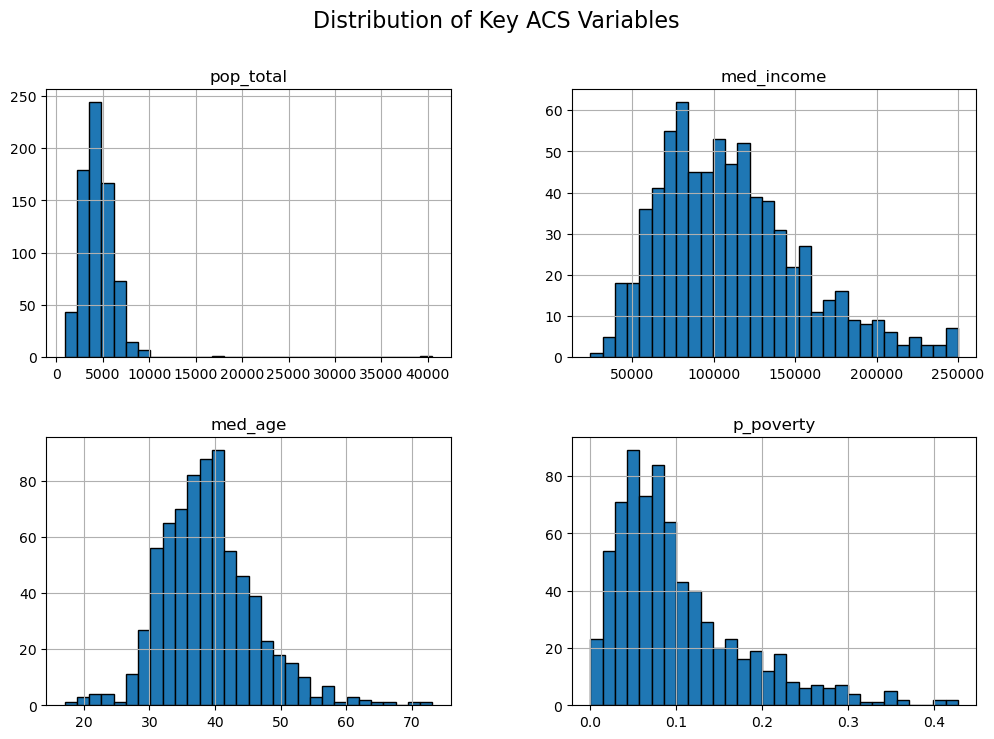

In [100]:
num_cols = ["pop_total", "med_income", "med_age", "p_poverty"]

acs[num_cols].hist(bins=30, figsize=(12, 8), edgecolor="black")
plt.suptitle("Distribution of Key ACS Variables", fontsize=16)
plt.show()

In [101]:
## Select 10 most populated tracts, making sure there are at least 3 coastal or 3 inland
most_pop_10 = acs.sort_values(by='pop_total')[:10]
most_pop_10['region'].value_counts()

region
coastal    7
inland     3
Name: count, dtype: int64

## Cleaning Asthma Data

In [102]:
# Load in data
asthma = pd.read_csv('asthmaedvisitrates-by-zipcode-2013to2022-allages-ca-cdph_with-county.csv')

In [103]:
## Only select San Diego county and drop NA
asthma_sd = asthma[asthma['county']=='San Diego'].dropna()

In [104]:
## Making sure the type and name of the zip code column is the same as in the AQI dataset
asthma_by_zipcode = pd.DataFrame(asthma_sd.groupby('Zip_Code')['Number_of_Asthma_ED_Visits'].mean()).reset_index()
asthma_by_zipcode['Zip_Code'] = asthma_by_zipcode['Zip_Code'].astype(int)
asthma_by_zipcode.columns = ['Zip Code', 'Number_of_Asthma_ED_Visits']
asthma_by_zipcode

,Zip Code,Number_of_Asthma_ED_Visits
0,91901,37.100
1,91902,40.000
2,91906,19.125
3,91910,323.400
4,91911,391.200
...,...,...
77,92130,45.700
78,92131,40.700
79,92139,148.600
80,92154,283.100


In [105]:
## check relationship between respiratory illness and how populated the zip codes are

## use proportion of respiratory illness by population

## EDA for Asthma Data

In [106]:
asthma_sd.describe()

,Year,Zip_Code,Number_of_Asthma_ED_Visits,Age_Adjusted_Rate_of_Asthma_ED_V
count,764.000000,764.000000,764.000000,764.000000
mean,2017.462042,92051.571990,120.323298,29.261518
std,2.872544,73.440064,108.509243,17.031483
min,2013.000000,91901.000000,12.000000,3.200000
25%,2015.000000,92010.750000,47.000000,17.000000
50%,2017.000000,92069.000000,82.000000,24.500000
75%,2020.000000,92114.000000,151.250000,36.750000
max,2022.000000,92173.000000,584.000000,107.200000


# Analysis

## ANOVA Testing for AQI Between the 10 Most Populated Coastal and Inland Zip Codes

### Checking Conditions

In order to do ANOVA testing, the data must fulfill 3 conditions.

First, each observation must be independent. This can be reasonably assumed to be fulfilled even though there are broader trends within the AQI score for each date, because our ANOVA testing does not discern based on date.

Next, the dependent variable must be normally distributed. We can check that with a histogram below. While the data has a slight right skew, it is not too far from having a Gaussian distribution, and thus this condition can be considered to be met.

Third, the variability between each group must be similar. This can be checked with a box plot below. The variability for Petco Park and La Jolla appear to be higher than the other regions. In order to mitigate this, we should drop outliers.

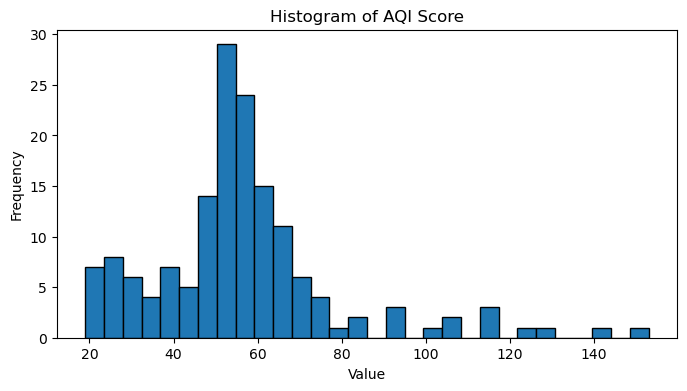

In [124]:
plt.hist(aqi_zip_df['AQI Score'], bins=30, edgecolor='black') # bins argument controls the number of bins
plt.title('Histogram of AQI Score')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

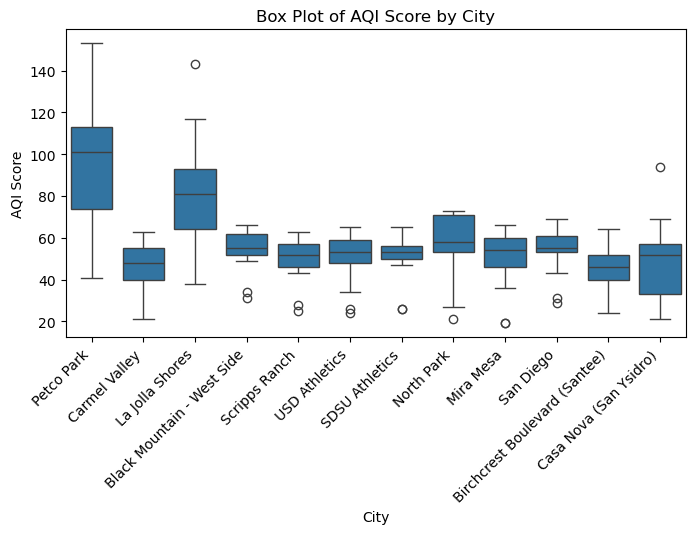

In [125]:
sns.boxplot(x='City', y='AQI Score', data=aqi_zip_df.reset_index())
plt.title('Box Plot of AQI Score by City')
plt.xticks(rotation=45, ha='right')
plt.show()

In [109]:
## Drop outliers


In [133]:
import scipy.stats as stats

In [153]:
aqi_zip_df['City'].unique()

petco = np.array(aqi_zip_df[aqi_zip_df['City']=='Petco Park']['AQI Score'])
carmel = np.array(aqi_zip_df[aqi_zip_df['City']=='Carmel Valley']['AQI Score'])
la_jolla = np.array(aqi_zip_df[aqi_zip_df['City']=='La Jolla Shores']['AQI Score'])
black_mtn = np.array(aqi_zip_df[aqi_zip_df['City']=='Black Mountain - West Side']['AQI Score'])
scripps = np.array(aqi_zip_df[aqi_zip_df['City']=='Scripps Ranch']['AQI Score'])
sdsu = np.array(aqi_zip_df[aqi_zip_df['City']=='SDSU Athletics']['AQI Score'])
north_park = np.array(aqi_zip_df[aqi_zip_df['City']=='North Park']['AQI Score'])
mira_mesa = np.array(aqi_zip_df[aqi_zip_df['City']=='Mira Mesa']['AQI Score'])
sd = np.array(aqi_zip_df[aqi_zip_df['City']=='San Diego']['AQI Score'])
santee = np.array(aqi_zip_df[aqi_zip_df['City']=='Birchcrest Boulevard (Santee)']['AQI Score'])
san_ysidro = np.array(aqi_zip_df[aqi_zip_df['City']=='Casa Nova (San Ysidro)']['AQI Score'])

In [156]:
f_statistic, p_value = stats.f_oneway(petco, carmel, la_jolla, black_mtn, scripps, sdsu, north_park, mira_mesa, sd, santee, san_ysidro)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 9.59833813111206
P-value: 6.793668690928445e-12


## Linear Regression for AQI and Rate of Asthma

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [130]:
aqi_asthma = pd.merge(aqi_zip_df, asthma_by_zipcode, how='left', on='Zip Code').dropna().groupby('Zip Code')[['AQI Score', 'Number_of_Asthma_ED_Visits']].mean()

,AQI Score,Number_of_Asthma_ED_Visits
Zip Code,,
92037,83.153846,44.444444
92071,45.076923,145.400000
92101,73.500000,183.100000
92104,55.000000,154.800000
92110,50.000000,68.000000
92126,51.230769,169.700000
92131,50.000000,40.700000
92173,49.384615,140.100000


In [131]:
x = np.array(aqi_asthma['AQI Score']).reshape(-1,1)
y = np.array(aqi_asthma['Number_of_Asthma_ED_Visits']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)
print(f"Slope (B1): {model.coef_[0]}")
print(f"Intercept (B0): {model.intercept_}")

Slope (B1): [-0.63938015]
Intercept (B0): [154.83281238]


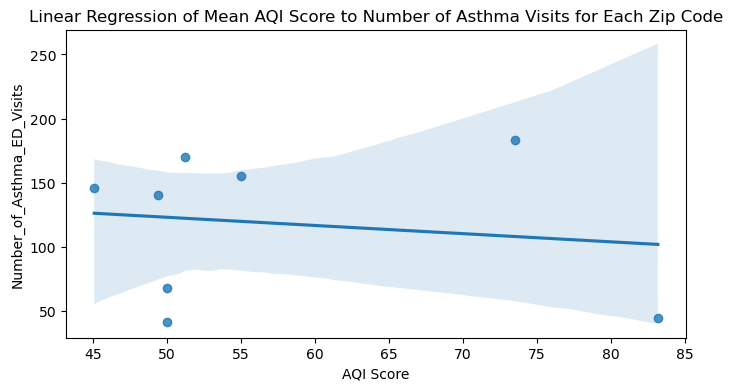

In [132]:
sns.regplot(x='AQI Score', y='Number_of_Asthma_ED_Visits', data=aqi_asthma)
plt.title('Linear Regression of Mean AQI Score to Number of Asthma Visits for Each Zip Code')
plt.show()

# Outline of Work for Completing the Project

Iain: Will obtain full AQI data and create clean visualizations for the first research question 

Christina: Will conduct T-test and ANOVA testing for the first research question. Will also write about the background and importance of the research questions.

Diego: Will conduct regression analysis between the AQI scores and respiratory illness rates for the second research question

John: Will create clean visualizations for the second research question and create the presentation slides.

All members will work on writing the conclusions.